<h1 align = "Center"> IST 5520 Spring 2020: Group 1 Project Proposal </h1>
<h2 align = "Center"> An Analysis of Vermont Crashes Data</h2>
<h3 align = "Center"> By: Bryce Cordry, Kyle Johnson, Matthew Kovar, Yitian Luo, Brian Middleton </h3>

# Introduction

Traffic crashes happen every day in the world and they rank as the 9th leading cause of death. In the United States, there are an average of 16,438 car accidents per day. Moreover, nearly 1.25 million people die in car accidents per year, by this we mean that, car accidents cause 3,287 deaths per day. （https://www.thewanderingrv.com/car-accident-statistics/) Therefore, it is important for us to get more information about car crashes and try to avoid them.

We found a dataset of car crashes in the State of Vermont from the year 2014 to 2018. We are considering the dataset from the perspective of an insurance company using telematics devices in vehicles to create individualized risk profiles for policyholders located in Vermont and set their premiums accordingly. We are interested in determining what kinds of characteristics are responsible for vehicle accidents and how to use this information to adjust a policyholder's future premium once they are in an accident. To be more specific, we want to figure out what matters the most in the accidents. Also, we hope to find out factors that lead to various outcomes (property damage, injury or fatal). In addition, we want to find out areas or roads that are most prone to accidents.

# Data Source and Collection

The dataset was downloaded from the Vermont Open Geodata Portal (https://geodata.vermont.gov/datasets/VTrans::vt-crashes-2018?orderBy=ACCIDENTDATE&orderByAsc=false). 
We combined the data from year 2014 to year 2018 and it contains 61,562 car accidents in Vermont. The data was collected by various reporting agencies within Vermont. 

This dataset contains 36 columns listed below. Some of the key information includes the type of injury, the impairment of the driver, the accident location, date, weather, the road conditions, as well as the reporting agency. All of this information can be useful for us in determining how the insured's future premiums will be adjusted.
 

- 	OBJECTID 
-   REPORTINGAGENCYid 
- 	ReportingAgency 
- 	REPORTNUMBER 
- 	ACCIDENTDATE 
- 	STREETADDRESS 
- 	INTERSECTIONWITH 
- 	DirOfCollision 
- 	RoadGroup 
- 	AOTACTUALMILEPOINT 
- 	RoadCharacteristics 
- 	NonReportableAddress 
- 	CITYORTOWNid 
- 	CITYORTOWN 
- 	EASTING 
- 	NORTHING
- 	AOTROUTEid 
-	AOTROUTE 
-	LRSNUMBER 
-	HOWMAPPED 
-	Animal 
-	Impairment 
-	Involving 
-	Weather 
-	DayNight 
-	InjuryType 
-	LOC_ERROR 
-	RDFLNAME 
-	SurfaceCondition 
-	RoadCondition 
-	Route 
-	LATITUDE 
-	LONGITUDE 
-	AOTROADWAYGROUPid 


# Technical Approach

### Data Manipulation

Use Pandas/Numpy/Scipy for datasets manipulation. First we merge the datasets from the years 2015-2018. Some columns are dropped due to inconsistent recording from year to year. (Some columns don't exist on certain years). They we remove columns which hold data which is not relevant to our analysis, such as internal Vermonet Department of Transportation ID codes posted to cities for which we already have the names. Then we begin handling NA's by replacing them with a filler value such as "Unknown" where it is appropriate. Following that, we fill NA values based upon the general distribution of known values (where appropriate). Where possible we try to intelligently fill NA's by using clues in the data, such as on Road and Surface Conditions, we fill NA's by the prevalent weather first, and distribution second. Finally we remove rows with remaining NA's and save the cleansed data.   

In [17]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import and clean data, deal with missing values
years = [2015, 2016, 2017, 2018]
df_dict = {year:pd.read_csv("VT_Crashes__{}.csv".format(str(year))) for year in years}

for year, df in df_dict.items():
  df_dict[year] = df.rename(columns={"ACCIDENTDA":"ACCIDENTDATE", 
                                     "AOTACTUALM":"AOTACTUALMILEPOINT",
                                     "INTERSECTI":"INTERSECTIONWITH",
                                     "STREETADDR":"STREETADDRESS",
                                     "REPORTNUMB":"REPORTNUMBER",
                                     "ReportingAgency":"REPORTINGAGENCY",
                                     "DirOfCollision":"DIROFCOLLI",
                                     "VCSG_LRSNUMBER":"LRSNUMBER",
                                     "REPORTINGA":"REPORTINGAGENCYid",
                                     "VCSG_EASTING":"EASTING",
                                     "VCSG_NORTHING":"NORTHING",
                                     "VCSG_AOTROUTE":"AOTROUTE",
                                     "VCSG_CITYORTOWN":"CITYORTOWN"})
  df_dict[year]["Year"] = year

df_dict[2018] = df_dict[2018].rename(columns={"LATITUDE":"LAT_DD","LONGITUDE":"LONG_DD"})
df_dict[2017] = df_dict[2017].rename(columns={"GIS_LATITUDE":"LAT_DD","GIS_LONGITUDE":"LONG_DD"})

df = pd.concat(df_dict.values(), sort=True)

#Drop Columns
df = df.drop(columns=['ACCIDENTTI','AOTROADWAYGROUPid','AOTROUTEid','CITYORTOWNid','MILEMARKER1','MILEMARKER_1',
                      'MILEMARKER_2','NUMBER','NUMBER1','NUMBER2','NUMBER3','OBJECTID','RDFLNAME','REPORTINGAGENCYid',
                      'VCSG_AOTROUTEid','VCSG_CITYORTOWNid','NORTHING','EASTING','DIRFROMNEA','CrashType',
                     'DISTANCE_1','POSTEDSPEE','VCSG_LATITUDE','VCSG_LONGITUDE','Route', 'AOTROADWAY'])

#Relabel NA's
df['AOTACTUALMILEPOINT'] = df['AOTACTUALMILEPOINT'].fillna("Unmarked")
#df['AOTROUTE'] = df['AOTROUTE'].fillna("Unknown")
#df['Animal'] = df['Animal'].fillna("Unknown")
#df['CITYORTOWN'] = df['CITYORTOWN'].fillna("Unknown")
#df['DIROFCOLLI'] = df['DIROFCOLLI'].fillna("Unknown")
#df['INTERSECTIONWITH'] = df['INTERSECTIONWITH'].fillna("Unknown")
#df['Impairment'] = df['Impairment'].fillna("None")
#df['Involving'] = df['Involving'].fillna("None")
#df['LOCALID'] = df['LOCALID'].fillna("Unknown")
df['LOC_ERROR'] =df['LOC_ERROR'].fillna("NO ERROR")
df['LRSNUMBER'] = df['LRSNUMBER'].fillna("None")
df['NonReportableAddress'] = df['NonReportableAddress'].fillna("Reportable")
df['RoadCharacteristics'] = df['RoadCharacteristics'].fillna("Other - Explain in Narrative")
#df['Weather'] = df['Weather'].fillna("Unknown")
#df['STREETADDRESS'] = df['STREETADDRESS'].fillna("Unknown")

#new distributions 4/23/2020
values_dist = df.Animal.value_counts(normalize=True)
missing = df['Animal'].isnull()
df.loc[missing,'Animal'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.Weather.value_counts(normalize=True)
missing = df['Weather'].isnull()
df.loc[missing,'Weather'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.Involving.value_counts(normalize=True)
missing = df['Involving'].isnull()
df.loc[missing,'Involving'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.Impairment.value_counts(normalize=True)
missing = df['Impairment'].isnull()
df.loc[missing,'Impairment'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

#Fill NA's based upon Distribution or other conditions
values_dist = df.DayNight.value_counts(normalize=True)
missing = df['DayNight'].isnull()
df.loc[missing,'DayNight'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.InjuryType.value_counts(normalize=True)
missing = df['InjuryType'].isnull()
df.loc[missing,'InjuryType'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

Freezing_Precipitation_df = df[(df['SurfaceCondition'].isin(['Snow','Ice','Slush','Wet']))]
values_dist = Freezing_Precipitation_df.SurfaceCondition.value_counts(normalize=True)
df['SurfaceCondition'] = np.where(((df.SurfaceCondition.isnull())& (df['Weather'] == 'Rain')),'Wet',df.SurfaceCondition)
df['SurfaceCondition'] = np.where(((df.SurfaceCondition.isnull())& (df['Weather'] == 'Clear')),'Dry',df.SurfaceCondition)
df['SurfaceCondition'] = np.where(((df.SurfaceCondition.isnull())& (df['Weather'] == 'Freezing Precipitation')),np.random.choice(values_dist.index,p=values_dist.values),df.SurfaceCondition)
df['RoadCondition'] = np.where(((df.RoadCondition.isnull())& (df['Weather'] == 'Freezing Precipitation')),'Road Surface Condition(wet, icy, snow, slush, etc)',df.RoadCondition)
df['RoadCondition'] = np.where(((df.RoadCondition.isnull())& (df['Weather'] == 'Rain')),'Road Surface Condition(wet, icy, snow, slush, etc)',df.RoadCondition)

values_dist = df.SurfaceCondition.value_counts(normalize=True)
missing = df['SurfaceCondition'].isnull()
df.loc[missing,'SurfaceCondition'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

values_dist = df.RoadCondition.value_counts(normalize=True)
missing = df['RoadCondition'].isnull()
df.loc[missing,'RoadCondition'] = np.random.choice(values_dist.index, size=len(df[missing]),p=values_dist.values)

#remove remaining NA's
#df = df.dropna()

df = df.astype(str)

df.reset_index(drop = True, inplace = True)

from datetime import datetime
from dateutil import parser
for i in range(len(df)):
    x = parser.isoparse(df['ACCIDENTDATE'][i])
    x = x.strftime('%Y-%m-%d %H:%M:%S')
    df['ACCIDENTDATE'][i] = x
    
df['ACCIDENTDATE'] = pd.to_datetime(df['ACCIDENTDATE'])    

df.to_csv("combined.csv")

null_count = df.isnull()
null_count.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   ACCIDENTDATE          49636 non-null  bool 
 1   AOTACTUALMILEPOINT    49636 non-null  bool 
 2   AOTROUTE              49636 non-null  bool 
 3   Animal                49636 non-null  bool 
 4   CITYORTOWN            49636 non-null  bool 
 5   DIROFCOLLI            49636 non-null  bool 
 6   DayNight              49636 non-null  bool 
 7   HOWMAPPED             49636 non-null  bool 
 8   INTERSECTIONWITH      49636 non-null  bool 
 9   Impairment            49636 non-null  bool 
 10  InjuryType            49636 non-null  bool 
 11  Involving             49636 non-null  bool 
 12  LAT_DD                49636 non-null  bool 
 13  LOCALID               49636 non-null  bool 
 14  LOC_ERROR             49636 non-null  bool 
 15  LONG_DD               49636 non-null  bool 
 16  LRSN

### Data Analysis

Analyze the different accidents type under different conditions. Data visualization including hot map of the areas that car crashes happened in Vermont and the histogram of the accidents under different situations.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ACCIDENTDATE          49636 non-null  datetime64[ns]
 1   AOTACTUALMILEPOINT    49636 non-null  object        
 2   AOTROUTE              49636 non-null  object        
 3   Animal                49636 non-null  object        
 4   CITYORTOWN            49636 non-null  object        
 5   DIROFCOLLI            49636 non-null  object        
 6   DayNight              49636 non-null  object        
 7   HOWMAPPED             49636 non-null  object        
 8   INTERSECTIONWITH      49636 non-null  object        
 9   Impairment            49636 non-null  object        
 10  InjuryType            49636 non-null  object        
 11  Involving             49636 non-null  object        
 12  LAT_DD                49636 non-null  object        
 13  LOCALID         

In [19]:
# Get the descriptive summary
df.describe().transpose()

,count,unique,top,freq,first,last
ACCIDENTDATE,49636,34929,2015-02-03 00:00:00,191,2015-01-01,2018-12-31 21:14:00
AOTACTUALMILEPOINT,49636,2484,999.99,16159,NaT,NaT
AOTROUTE,49636,2463,Unknown,6092,NaT,NaT
Animal,49636,5,None/Other,48034,NaT,NaT
CITYORTOWN,49636,254,Burlington,5473,NaT,NaT
DIROFCOLLI,49636,23,nan,12515,NaT,NaT
DayNight,49636,2,Day,37372,NaT,NaT
HOWMAPPED,49636,5,LRS,32244,NaT,NaT
INTERSECTIONWITH,49636,19602,nan,9455,NaT,NaT
Impairment,49636,4,None,46992,NaT,NaT


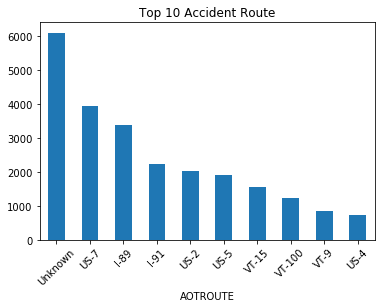

In [20]:
# Summarization statistics
AOTR=pd.crosstab(index=df['AOTROUTE'],columns="Count")
AOTR=AOTR.sort_values(by='Count',ascending=False).head(10)
AOTR.plot(kind='bar', legend = False)
plt.title('Top 10 Accident Route')
plt.xticks(rotation=45)
plt.show()

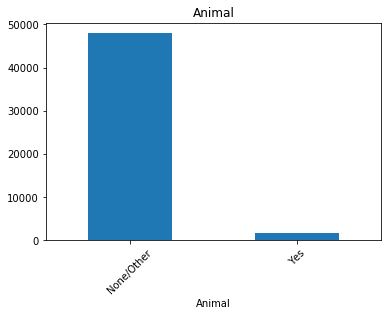

In [21]:
df['Animal'] = np.where((df['Animal'] == 'Deer'),'Yes',df.Animal)
df['Animal'] = np.where((df['Animal'] == 'Domestic'),'Yes',df.Animal)
df['Animal'] = np.where((df['Animal'] == 'Moose'),'Yes',df.Animal)
df['Animal'] = np.where((df['Animal'] == 'Wild'),'Yes',df.Animal)
Ani=pd.crosstab(index=df['Animal'],columns="Count")
Ani=Ani.sort_values(by='Count',ascending=False)
Ani.plot(kind='bar', legend = False)
plt.title('Animal')
plt.xticks(rotation=45)
plt.show()

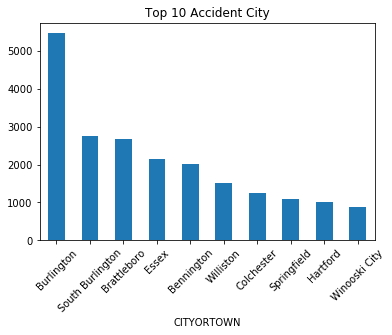

In [22]:
CITY=pd.crosstab(index=df['CITYORTOWN'],columns="Count")
CITY=CITY.sort_values(by='Count',ascending=False).head(10)
CITY.plot(kind='bar', legend = False)
plt.title('Top 10 Accident City')
plt.xticks(rotation=45)
plt.show()

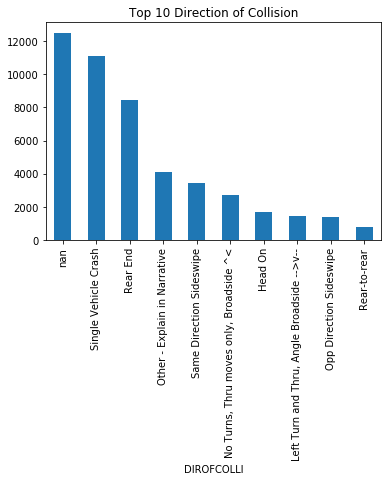

In [23]:
DIRE=pd.crosstab(index=df['DIROFCOLLI'],columns="Count")
DIRE=DIRE.sort_values(by='Count',ascending=False).head(10)
DIRE.plot(kind='bar', legend = False)
plt.title('Top 10 Direction of Collision')
plt.show()

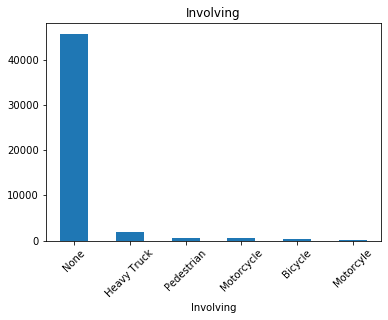

In [24]:
Inv=pd.crosstab(index=df['Involving'], columns="Count")
Inv=Inv.sort_values(by='Count',ascending=False)
Inv.plot(kind='bar', legend = False)
plt.title('Involving')
plt.xticks(rotation=45)
plt.show()

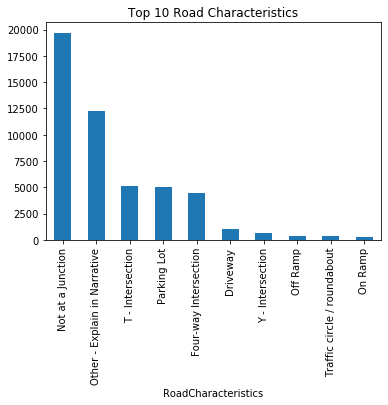

In [25]:
RoadChar=pd.crosstab(index=df['RoadCharacteristics'],columns="Count")
RoadChar=RoadChar.sort_values(by='Count', ascending=False).head(10)
RoadChar.plot(kind='bar', legend = False)
plt.title('Top 10 Road Characteristics')
plt.show()

From the above cross-tab graph, we conclude that most car crashes took place in the city called Burlington and the US-7 route. Based on our research, this makes sense because Burlington is the biggest city in Vermont State and US-7 route crosses the city of Burlington.

In [26]:
# Contigency tables
pd.crosstab(df['InjuryType'],df['Weather'], margins=True)

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Unknown,Wind,All
InjuryType,,,,,,,
Fatal,147,42,16,16,55,1,277
Injury,4849,1614,856,630,1887,24,9860
Property Damage Only,17887,6093,3779,2107,9549,84,39499
All,22883,7749,4651,2753,11491,109,49636


In [27]:
pd.crosstab(df['InjuryType'],df['DayNight'], margins=True)

DayNight,Day,Night,All
InjuryType,,,
Fatal,175,102,277
Injury,7132,2728,9860
Property Damage Only,30065,9434,39499
All,37372,12264,49636


In [28]:
pd.crosstab( df['SurfaceCondition'], df['Weather'], margins=True)

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Unknown,Wind,All
SurfaceCondition,,,,,,,
Dry,21185,5013,43,33,7678,41,33993
Ice,329,330,548,48,435,10,1700
Not Reported,14,6,0,1,25,0,46
Other - Explain in Narrative,52,30,16,5,38,1,142
"Sand, mud, dirt, oil, gravel",106,61,4,25,65,0,261
Slush,83,113,231,29,129,1,586
Snow,359,636,3525,15,1347,44,5926
Unknown,93,65,16,12,362,2,550
Water (standing / moving),2,6,5,67,15,0,95


In [29]:
pd.crosstab(df['DIROFCOLLI'],df['Weather'], margins=True)

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Unknown,Wind,All
DIROFCOLLI,,,,,,,
Head On,902,304,329,111,40,6,1692
"Left Turn and Thru, Angle Broadside -->v--",941,276,70,97,28,2,1414
"Left Turn and Thru, Broadside v<--",444,132,41,53,10,2,682
"Left Turn and Thru, Head On ^v--",138,44,10,14,5,0,211
"Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--",193,66,15,19,6,0,299
"Left Turns, Opposite Directions, Head On/Angle Crash --^v--",41,10,1,7,0,0,59
"Left Turns, Same Direciton, Rear End v--v--",9,2,1,2,0,0,14
"Left Turns, Same Direction, Rear End v--v--",30,10,2,2,1,0,45
"Left and Right Turns, Simultaneous Turn Crash --vv--",52,13,5,6,5,0,81


We created the contigency table to see how factors related generally. We concluded that most acciednts were happened during daytime when the weather is fine, and the major damage type is property damage.

## Correlation Analysis

In this section, we take a look at two methods to calculate correlations. Below are the packages used for these excercises.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import itertools
from matplotlib import pyplot as plt

### Simple Correlation
First, we need to reload our dataset for calculating the correlation between variables.

In [31]:
corr_df = pd.read_csv('combined.csv')
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            49636 non-null  int64  
 1   ACCIDENTDATE          49636 non-null  object 
 2   AOTACTUALMILEPOINT    49636 non-null  object 
 3   AOTROUTE              49299 non-null  object 
 4   Animal                49636 non-null  object 
 5   CITYORTOWN            49505 non-null  object 
 6   DIROFCOLLI            37121 non-null  object 
 7   DayNight              49636 non-null  object 
 8   HOWMAPPED             49110 non-null  object 
 9   INTERSECTIONWITH      40181 non-null  object 
 10  Impairment            49636 non-null  object 
 11  InjuryType            49636 non-null  object 
 12  Involving             49636 non-null  object 
 13  LAT_DD                49110 non-null  float64
 14  LOCALID               39326 non-null  float64
 15  LOC_ERROR          

Next, we will calculate the correlation using the .corr() method

Text(0.5, 1, 'Basic Correlation')

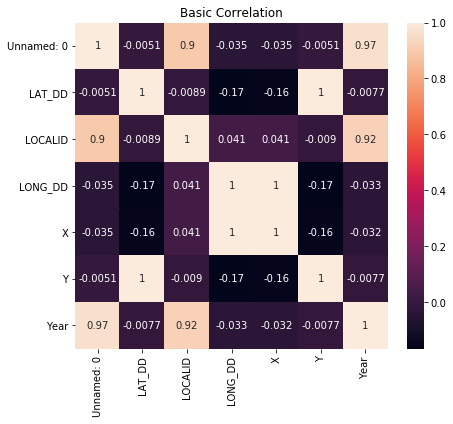

In [32]:
correlation = corr_df.corr()

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(correlation, annot=True, ax=ax) 
ax.set_title("Basic Correlation")

As you can see, the function worked, however only on the numeric data we have in our dataset. This data used in the correlation analysis used variables such as year, latitude, and longitude. 
As they're only useful to us as identifiers, this analysis isn't useful. Although, it does help us confirm that X is the same as Latitude, and Y is the same as Longitude

### Cramer's V Correlation
In researching potential correlation calculations for our dataset, which mainly is composed of categorical data, we discovered an algorithm that computes correlation on categorical variables.
Note that the following code is taken from a research paper and cited within the following function.

The first step is to chose which columns from the dataset we would like to calculate. We chose every column that was of type "object", and then further reduced the columns to eliminate redundancy.

In [33]:
# We need to choose columns to correlate
chosen_cols = ['Animal','CITYORTOWN','DIROFCOLLI','DayNight',
                 'Impairment', 'InjuryType','Involving','LOCALID','RoadCharacteristics','SurfaceCondition',
                 'Weather','INTERSECTIONWITH']

Next, we define the function used for the calculation of the correlations.

In [34]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

The third step is to run the calculations and save them into a correlation matrix. The try/except statements are there to handle a specific error that occurs within our data. The crosstabulation for a few combinations of variables is much too large to compute, so we utilize an except statement to replace those values with 0. There might be a small correlation, but without further reduction of one of the variables we cannot tell. We chose not to reduce the troubling variable, INTERSECTIONWITH, to ensure that the quality of data remains as high as possible.

In [35]:
# Code taken from https://www.kaggle.com/phaethonprime/eda-and-logistic-regression
# Adjusted to fit our dataset
corr_matrix = np.zeros((len(chosen_cols),len(chosen_cols)))

for col1, col2 in itertools.combinations(chosen_cols, 2):
    try:
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(corr_df[col1], corr_df[col2]))
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]
    except:
        # If an error is thrown, replace the correlation value with 0.00
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = 0.00
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

The final step is to plot the correlation using a heatmap.

Text(0.5, 1, 'Cramer V Correlation')

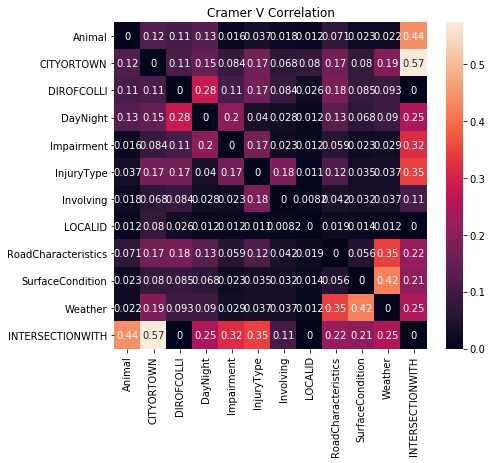

In [36]:
corr = pd.DataFrame(corr_matrix, index=chosen_cols, columns=chosen_cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Cramer V Correlation")

As the above plot shows us, there are not many strong correlations. Some of the stronger correlations makes sense - INTERSECTIONWITH names roads that exist within CITYORTOWN - but some of them are still interesting.

At a high level, INTERSECTIONWITH and Animal only have a correlation of .43, but this suggests that there are particular intersections that have more animal related car crashes.
Similarily, INTERSECTIONWITH and Impairment also have a slightly stronger correlation, which suggests that there are hotspots of alchol use.
The story gets more interesting when we look at DIROFCOLLI and Weather. Why would weather determine the direction of collision? Let's explore this relationship.

In [37]:
# Crosstab of DIROFCOLLI and Weather
pd.crosstab(corr_df['DIROFCOLLI'],corr_df['Weather'])

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Unknown,Wind
DIROFCOLLI,,,,,,
Head On,902,304,329,111,40,6
"Left Turn and Thru, Angle Broadside -->v--",941,276,70,97,28,2
"Left Turn and Thru, Broadside v<--",444,132,41,53,10,2
"Left Turn and Thru, Head On ^v--",138,44,10,14,5,0
"Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--",193,66,15,19,6,0
"Left Turns, Opposite Directions, Head On/Angle Crash --^v--",41,10,1,7,0,0
"Left Turns, Same Direciton, Rear End v--v--",9,2,1,2,0,0
"Left Turns, Same Direction, Rear End v--v--",30,10,2,2,1,0
"Left and Right Turns, Simultaneous Turn Crash --vv--",52,13,5,6,5,0


We need to clean the DIROFCOLLI column a little more. We will remove unknowns and group the values together, generate a new confusion matrix, then recalculate Cramer's V.

In [38]:
# Removing Unknowns from data
df2 = corr_df
df2 = df2[df2.DIROFCOLLI != 'Unknown']
df2 = df2[df2.Weather != 'Unknown']

# Grouping values in DIROFCOLLI
# Create groups of values
b_list = ['Left Turn and Thru, Angle Broadside -->v--','Left Turn and Thru, Broadside v<--', 
          'No Turns, Thru moves only, Broadside ^<', 'Right Turn and Thru, Angle Broadside -->^--', 
          'Right Turn and Thru, Broadside ^<--']
h_list = ['Left Turn and Thru, Head On ^v--', 'Left Turns, Opposite Directions, Head On/Angle Crash --^v--', 'Right Turn and Thru, Head On v^--']
s_list = ['Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--','Left and Right Turns, Simultaneous Turn Crash --vv--', 
          'Opp Direction Sideswipe','Right Turn and Thru, Same Direction Sideswipe/Angle Crash ^^--','Same Direction Sideswipe']
r_list = ['Left Turns, Same Direction, Rear End v--v--','Left Turns, Same Direciton, Rear End v--v--','Rear-to-rear','Right Turn, Same Direciton, Rear End ^--^--',
          'Right Turn, Same Direction, Rear End ^--^--']
            
# Loop through column and replace values
for i in b_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Broadside')
for i in h_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Head On')
for i in s_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Sideswipe')
for i in r_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Rear End')

In [39]:
#  New Crosstab of DIROFCOLLI and Weather
new_crosstab = pd.crosstab(df2['DIROFCOLLI'],df2['Weather'])
new_crosstab

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Wind
DIROFCOLLI,,,,,
Broadside,3269,1041,411,356,9
Head On,1102,363,351,136,6
Other - Explain in Narrative,2361,772,369,234,6
Rear End,5978,1867,671,555,18
Sideswipe,3300,1071,500,323,12
Single Vehicle Crash,5547,2183,2082,978,49


In [40]:
cramers_corrected_stat(new_crosstab)

0.08687688834599953

As you can see, the correlation of 41% was misleading. The actual value is closer to **8%**. The unknowns available in the original data were skewing the calculation, so there really isn't a correlation there. Since we can see how misleading this correlation is, lets look at the relationship between INTERSECTIONWITH and the other variables with greater than 40% correlation.

In [41]:
pd.crosstab(corr_df['INTERSECTIONWITH'],corr_df['Animal'])

Animal,Deer,Domestic,Moose,None/Other,Wild
INTERSECTIONWITH,,,,,
Leicester Whiting Rd,0,0,0,1,0
Taranovich Field,0,0,0,1,0
"""L"" Street",0,0,0,2,0
"""Sharp Corner""",0,0,0,1,0
"""Truly Unique""",0,0,0,1,0
...,...,...,...,...,...
pine St,0,0,0,1,0
s Prospect St,0,0,0,1,0
s Winooski Ave,0,0,0,1,0


The crosstab shows a lot of values for INTERSECTIONWTIH, but we want to keep as many values as possible so we are going to reduce the animal column and then recalculate 

In [42]:
# Grouping values in DIROFCOLLI
# Create groups of values
a_list = ['Animal','Deer','Domestic','Moose','Unknown','Wild']
            
# Loop through column and replace values
for i in a_list:
    df2['Animal'] = df2['Animal'].replace(i, 'Animal Hit')

df2['Animal'] = df2['Animal'].replace('None/Other','No Animal Hit')


intersection_animal = pd.crosstab(df2['INTERSECTIONWITH'],df2['Animal'])


cramers_corrected_stat(intersection_animal)

0.41729991764318886

The correlation lowered a bit but still suggests that there is a small correlation between these variables. We will repeat the process one more time to check INTERSECTIONWITH and Impairment

In [43]:
# Grouping values in DIROFCOLLI
# Create groups of values
i_list = ['Alcohol','Alcohol and Drugs','Drugs']
            
# Loop through column and replace values
for i in i_list:
    df2['Impairment'] = df2['Impairment'].replace(i, 'Impaired')

df2['Impairment'] = df2['Impairment'].replace('None','Not Impaired')

intersection_impairment= pd.crosstab(df2['INTERSECTIONWITH'],df2['Impairment'])


cramers_corrected_stat(intersection_impairment)

0.31387416258538603

This had the same effect as the previous correlation. Let's revisualize the correlation chart again.

Text(0.5, 1, 'Final Cramer V Correlation')

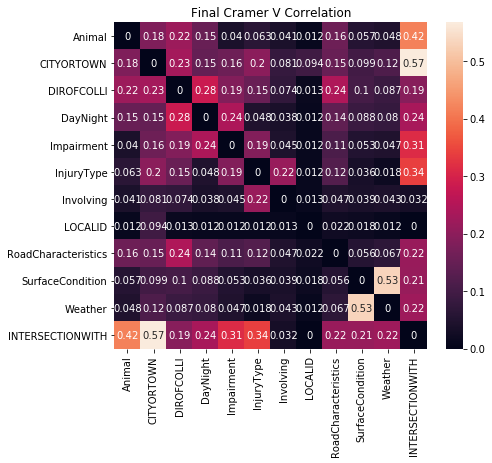

In [44]:
corr_matrix = np.zeros((len(chosen_cols),len(chosen_cols)))

for col1, col2 in itertools.combinations(chosen_cols, 2):
    try:
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df2[col1], df2[col2]))
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]
    except:
        # If an error is thrown, replace the correlation value with 0.00
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = 0.00
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

        
corr = pd.DataFrame(corr_matrix, index=chosen_cols, columns=chosen_cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Final Cramer V Correlation")

Interestingly, after cleaning the data some more, we see a stronger correlation between weather and surface condition. This is a relationship we assumed would be visible, as the weather determines if a road is icy or wet for the most part.

In [45]:
# import packages
import numpy as np
import pandas as pd

import re
import seaborn as sns
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

In [46]:
# read in data
df = pd.read_csv('./combined.csv')

In [47]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            49636 non-null  int64  
 1   ACCIDENTDATE          49636 non-null  object 
 2   AOTACTUALMILEPOINT    49636 non-null  object 
 3   AOTROUTE              49299 non-null  object 
 4   Animal                49636 non-null  object 
 5   CITYORTOWN            49505 non-null  object 
 6   DIROFCOLLI            37121 non-null  object 
 7   DayNight              49636 non-null  object 
 8   HOWMAPPED             49110 non-null  object 
 9   INTERSECTIONWITH      40181 non-null  object 
 10  Impairment            49636 non-null  object 
 11  InjuryType            49636 non-null  object 
 12  Involving             49636 non-null  object 
 13  LAT_DD                49110 non-null  float64
 14  LOCALID               39326 non-null  float64
 15  LOC_ERROR          

## Dimension Reduction

### Pre-processing

Due to the immense size of the dataset, we must first reduce dimensions manaully based upon intuition derived from background knoweledge of transportation systems.

The AOTRoute column indicates the route number or road name on which the accident occurred. We will do a frequency analysis to determine the routes with highest crash volumes, to see if there are any surprises.

In [48]:
# frequency analyis for AOTRoute
df['AOTROUTE'].value_counts().head(20)

Unknown         6092
US-7            3928
I-89            3372
I-91            2233
US-2            2038
US-5            1918
VT-15           1568
VT-100          1228
VT-9             861
US-4             720
VT-2A            643
VT-30            554
VT-11            502
MinCollector     490
VT-14            486
US-302           430
VT-105           397
VT-116           393
VT-7A            352
VT-103           341
Name: AOTROUTE, dtype: int64

We will keep the ten routes with highest crash volume, and create dummy variables for each. 

In [49]:
# scale down
AOTRoute = pd.Series(np.where(((df['AOTROUTE'] != 'US-7')&(df['AOTROUTE'] != 'I-89')&
                            (df['AOTROUTE'] != 'I-91')&(df['AOTROUTE'] != 'US-2')&
                            (df['AOTROUTE'] != 'US-5')&(df['AOTROUTE'] != 'VT-15')&
                            (df['AOTROUTE'] != 'VT-100')&(df['AOTROUTE'] != 'VT-9')&
                            (df['AOTROUTE'] != 'VT-2A')&(df['AOTROUTE'] != 'US-4')),'Other',df.AOTROUTE))
AOTRoute = pd.get_dummies(AOTRoute)

The Animal column indicates whether an animal is involved, and if so, what kind (for example, deer, domestic, moose, etc). For purposes of dimension reduction, we will reduce this down to only indicate if an animal is involved or not.

In [50]:
# get dummies for animal --> get "none" column for yes/no
animal = pd.get_dummies(df['Animal'])['None/Other']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
animal = pd.Series(np.where(np.array(animal)==0,1,0))

The CityOrTown Column indicates the jurisdiction in which the accident took place. Like the AOTRoute column, we will do a frequency analysis to see the cities with the highest crash volume.

In [51]:
# frequency analyis for CITYORTOWN
df['CITYORTOWN'].value_counts().head(20)

Burlington          5473
South Burlington    2763
Brattleboro         2667
Essex               2149
Bennington          2014
Williston           1501
Colchester          1259
Springfield         1091
Hartford            1019
Winooski City        882
Middlebury           838
Milton               822
Stowe                689
Rutland City         657
Montpelier           552
Barre City           497
Richmond             452
Morristown           444
Shelburne            443
St. Johnsbury        440
Name: CITYORTOWN, dtype: int64

We will keep the ten jurisdictions with highest crash volume, and create dummy variables for each.

In [52]:
# scale down
city_town = pd.Series(np.where(((df['CITYORTOWN'] != 'Burlington')&(df['CITYORTOWN'] != 'Brattleboro')&
                            (df['CITYORTOWN'] != 'South Burlington')&(df['CITYORTOWN'] != 'Essex')&
                            (df['CITYORTOWN'] != 'Bennington')&(df['CITYORTOWN'] != 'Williston')&
                            (df['CITYORTOWN'] != 'Colchester')&(df['CITYORTOWN'] != 'Springfield')&
                            (df['CITYORTOWN'] != 'Hartford')&(df['CITYORTOWN'] != 'Milton')),'Other',df.CITYORTOWN))
city_town = pd.get_dummies(city_town)

For the Day/Night and Impairment columns, we will select a "non-null" case to create a "yes/no" situation. Once we create the dummies, a 1 will be the "yes" case and a 0 will be the "no" case.

In [53]:
# DayNight --> save "night" case only as yes/no
night=pd.get_dummies(df['DayNight'])['Night']

In [54]:
# Impairment --> get "none" column for yes/no
impairment=pd.get_dummies(df['Impairment'])['None']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
impairment = pd.Series(np.where(np.array(impairment)==0,1,0))

For the Injury, Involving, Road Condition, Surface Condition, and Weather columns, we will create dummy variables for each situation, then drop the "null" case.

In [55]:
# get dummies for Injury
injury = pd.get_dummies(df['InjuryType'])
# remove "property damage only" which is the null case
injury = injury.drop(columns=['Property Damage Only'])

In [56]:
# get dummies for Involving
involving = pd.get_dummies(df['Involving'])
# remove "none" column which is the null case
involving = involving.drop(columns = ['None'])

In [57]:
# Get dummies for road condition
roadcondition = pd.get_dummies(df['RoadCondition'])
# drop "none" column which is the null case, unreported situations, and the surface condition; will add in later
roadcondition = roadcondition.drop(columns=['None', 'Other - Explain in Narrative', 'Not reported', 'Unknown',
                                            'Road Surface Condition(wet, icy, snow, slush, etc)'])

In [58]:
# get dummies for surface condition
surfacecondition = pd.get_dummies(df['SurfaceCondition'])
# drop "dry" column which is the null case along with unreported situations
surfacecondition = surfacecondition.drop(columns=['Dry', 'Not Reported', 'Other - Explain in Narrative', 'Unknown'])

In [59]:
# get dummies for weather
weather = pd.get_dummies(df['Weather'])
# drop "clear" column which is the null case along with unreported situations
weather = weather.drop(columns=['Clear', 'Unknown'])

We also would like to look at the seasons. To do this we need to extract the month from the dates. After extracting the month, we use conditional logic to generalize the month to a season.

In [60]:
# get accident dates
datetime = df['ACCIDENTDATE']
months = '' # new string
# use loop to extract month from date string
for i in range(len(datetime)):
    match = re.search(r'\d{4}-\d{2}-\d{2}', datetime[i]).group()
    months += match[5:7] + ','
# remove last extraneous comma from loop
months = months[:-1]
# split comma separated string
months = months.split(",")
# convert to DataFrame
months = pd.Series(months)

In [61]:
# determine season
seasons = ""
for i in range(len(months)):
    if months[i]=='12':
        seasons += 'Winter' + ','
    if months[i]=='01':
        seasons += 'Winter' + ','
    if months[i]=='02':
        seasons += 'Winter' + ','
    if months[i]=='03':
        seasons += 'Spring' + ','
    if months[i]=='04':
        seasons += 'Spring' + ','
    if months[i]=='05':
        seasons += 'Spring' + ','
    if months[i]=='06':
        seasons += 'Summer' + ','
    if months[i]=='07':
        seasons += 'Summer' + ','
    if months[i]=='08':
        seasons += 'Summer' + ','
    if months[i]=='09':
        seasons += 'Fall' + ','
    if months[i]=='10':
        seasons += 'Fall' + ','
    if months[i]=='11':
        seasons += 'Fall' + ','
# remove last extraneous comma from loop
seasons = seasons[:-1]
# split comma separated string
seasons = seasons.split(",")
# convert to DataFrame
seasons = pd.Series(seasons)
seasons = pd.get_dummies(seasons)

During our data manipulation phase, we assembled our dummy variables into series or dataframes. Here we will combine these together to pass to the PCA method.

In [62]:
# Build data frame for PCA
pca_df = pd.concat([animal, night, impairment], axis=1)
pca_df.columns=['Animal', 'Night', 'Impairment']
pca_df = pd.concat([pca_df, AOTRoute, city_town, injury, involving, roadcondition, surfacecondition, weather, seasons],
                   axis=1, sort=False)
pca_df

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Water (standing / moving),Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49631,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
49632,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
49633,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
49634,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [63]:
# look at dataframe
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 54 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   Animal                                                    49636 non-null  int32
 1   Night                                                     49636 non-null  uint8
 2   Impairment                                                49636 non-null  int32
 3   I-89                                                      49636 non-null  uint8
 4   I-91                                                      49636 non-null  uint8
 5   Other                                                     49636 non-null  uint8
 6   US-2                                                      49636 non-null  uint8
 7   US-4                                                      49636 non-null  uint8
 8   US-5                                

### Principal Component Analysis

Here we will do the Principal Component Analysis. To start we will run the PCA with all 53 dummy variable predictors.

In [64]:
# do PCA with full 53 components
pca_full = PCA(n_components=53)
# fit model
pca_full.fit(pca_df)

PCA(copy=True, iterated_power='auto', n_components=53, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [65]:
# check to see how much variance each explains
var_full = pca_full.explained_variance_ratio_
print(var_full)

[1.10279427e-01 9.32767087e-02 8.81878605e-02 7.74172720e-02
 7.31899479e-02 6.05924479e-02 5.24925676e-02 4.93346614e-02
 4.24387526e-02 3.74565831e-02 3.06663548e-02 2.36000232e-02
 2.18111745e-02 1.87810299e-02 1.79701045e-02 1.57425469e-02
 1.48699740e-02 1.38755639e-02 1.32134633e-02 1.21739788e-02
 1.16147487e-02 1.01346372e-02 9.83517643e-03 9.55598986e-03
 8.94601522e-03 8.80962728e-03 8.21640808e-03 7.44032577e-03
 7.26952964e-03 7.20151379e-03 5.87215873e-03 5.38639221e-03
 4.42278322e-03 4.12772156e-03 3.68345828e-03 3.49476325e-03
 3.33786387e-03 2.55298194e-03 1.78360874e-03 1.72260220e-03
 1.44882234e-03 1.33310664e-03 9.80148888e-04 8.42844327e-04
 7.15608337e-04 6.07985648e-04 5.50060745e-04 4.23714874e-04
 1.72757016e-04 7.97069093e-05 6.64958162e-05 5.18910713e-28
 4.14258650e-28]


In [66]:
# see cumulative variance
var_full_cumul = np.cumsum(np.round(pca_full.explained_variance_ratio_, decimals=4)*100)

print(var_full_cumul)

[ 11.03  20.36  29.18  36.92  44.24  50.3   55.55  60.48  64.72  68.47
  71.54  73.9   76.08  77.96  79.76  81.33  82.82  84.21  85.53  86.75
  87.91  88.92  89.9   90.86  91.75  92.63  93.45  94.19  94.92  95.64
  96.23  96.77  97.21  97.62  97.99  98.34  98.67  98.93  99.11  99.28
  99.42  99.55  99.65  99.73  99.8   99.86  99.92  99.96  99.98  99.99
 100.   100.   100.  ]


Text(0, 0.5, 'Cumulative Variance Explained')

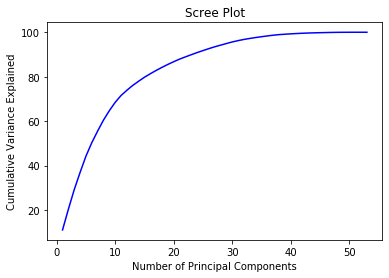

In [67]:
var1 = pd.DataFrame(var_full_cumul, index=np.arange(1,54))
plt.plot(var1,color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')

According to the scree plot, we would still have 90% representativeness if we pare down the number of predictors to 25.

In [68]:
# choose 25 component solution
# Select the number of components
pca25 = PCA(n_components=25)
pca25.fit(pca_df)
data_pca25 = pca25.transform(pca_df)

# Convert the numpy array to pandas DataFrame
data_pca25 = pd.DataFrame(data_pca25)
data_pca25.columns = ["PC"+str(i) for i in range(1,26)]

# Show the head of the DataFrame
data_pca25.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,0.671275,0.298448,-0.397331,-0.169590,-0.125491,-0.370182,0.022156,-0.237916,0.054687,-0.434836,...,0.002789,-0.030074,-0.056563,-0.042896,-0.015732,0.021884,0.005561,-0.002149,-0.022356,0.034335
1,1.329355,0.152377,-0.565112,0.027125,-0.030336,0.630700,-0.296366,0.914387,0.101612,0.558699,...,-0.142600,-0.112112,0.010485,-0.043033,-0.032028,0.018723,0.012221,-0.051160,-0.038084,-0.004188
2,0.852119,0.127025,-0.523193,0.009456,-0.140315,0.681674,0.180997,-0.296081,-0.073908,-0.440011,...,0.817442,0.145738,0.055490,0.070157,0.044756,0.010624,-0.017142,-0.026926,0.037129,0.004706
3,0.266699,0.749423,0.807663,0.163966,-0.110629,0.866625,0.147871,-0.052526,-0.017744,-0.419609,...,-0.024312,-0.143553,0.051883,-0.505512,0.098871,0.098621,-0.291140,0.037258,0.068089,0.260734
4,1.048276,0.354044,-0.502786,0.061804,-0.065288,0.443965,0.204579,-0.248304,-0.748112,0.603944,...,-0.023625,-0.100568,-0.468130,-0.140255,0.048908,0.039351,0.027031,0.275512,0.013042,0.016916
5,0.852119,0.127025,-0.523193,0.009456,-0.140315,0.681674,0.180997,-0.296081,-0.073908,-0.440011,...,0.817442,0.145738,0.055490,0.070157,0.044756,0.010624,-0.017142,-0.026926,0.037129,0.004706
6,0.828605,-0.039798,0.504191,-0.103765,-0.085739,-0.365447,-0.032922,-0.278744,0.022980,-0.424982,...,0.069451,-0.024838,0.012538,-0.216752,-0.016865,-0.071067,0.118321,-0.035423,-0.174802,-0.365127
7,0.339965,0.621941,0.988207,0.008928,-0.095494,-0.110362,0.037948,-0.035649,0.103594,-0.415321,...,0.019606,0.103250,0.024299,-0.113559,0.034931,0.648883,0.121967,-0.015359,-0.090991,-0.331645
8,0.152581,1.052815,-0.161621,0.092905,-0.149738,0.850325,0.191654,-0.026236,0.024856,-0.441286,...,-0.076649,-0.081382,-0.060665,-0.040674,-0.007272,-0.042858,0.051549,0.010152,-0.062327,-0.021325
9,0.671275,0.298448,-0.397331,-0.169590,-0.125491,-0.370182,0.022156,-0.237916,0.054687,-0.434836,...,0.002789,-0.030074,-0.056563,-0.042896,-0.015732,0.021884,0.005561,-0.002149,-0.022356,0.034335


In [69]:
#correlation analysis
pca25_corr = data_pca25.corr()

Text(0.5, 1, 'Basic Correlation')

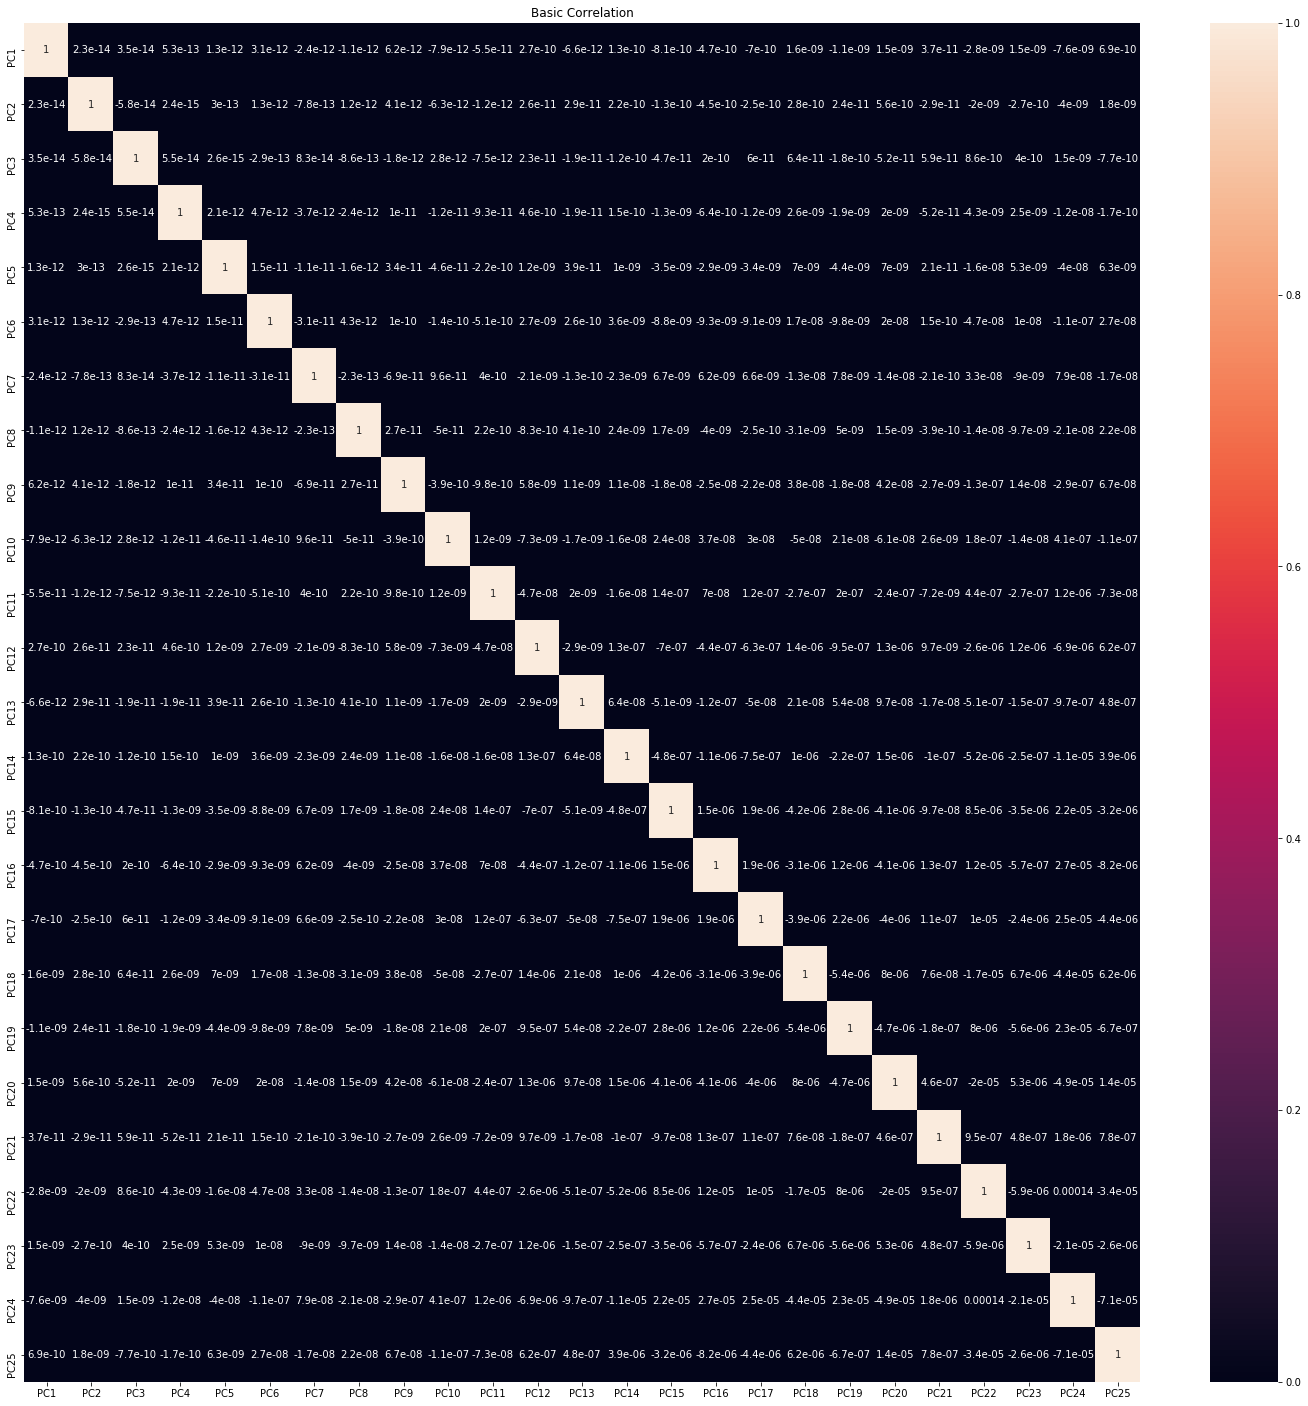

In [70]:
# visualize correlation
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(pca25_corr, annot=True, ax=ax) 
ax.set_title("Basic Correlation")

According to the visualization, there is very little multicollinearity issue in the 25-predictor PCA. This means that there is at least some semblance of a pattern to predict what causes accidents (despite having no non-examples in the dataset). 

## Machine Learning

Conduct the regression and time series analysis to provide the future prediction for the premiums. This step will be performed during Milestone 3.

# Business Questions

After understanding where the data comes from and what it includes, we are able to simplify our business questions down to the following: 

1. Which factors cause accidents?
2. Which factors best determine the outcome of an accident
3. Which roads are most prone to accidents, and how can we improve them?